In [1]:
import glob
import time

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

import sklearn
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

-----------------------
None
ffmpeg -version
-----------------------


In [2]:
from src.features import extract_features, get_hog_features
from src.utils import *
from src.search import Search

## Import data and visualiza some samples

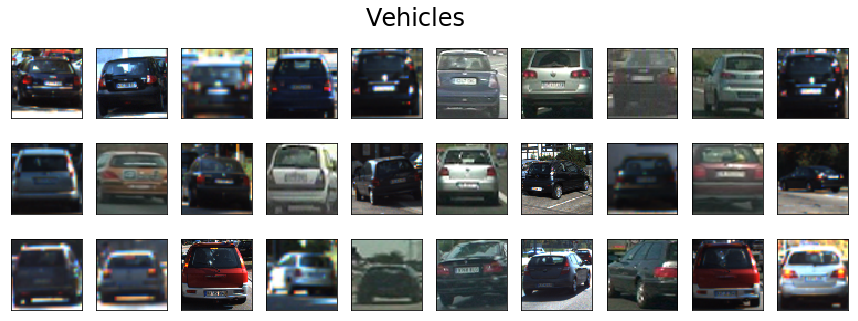

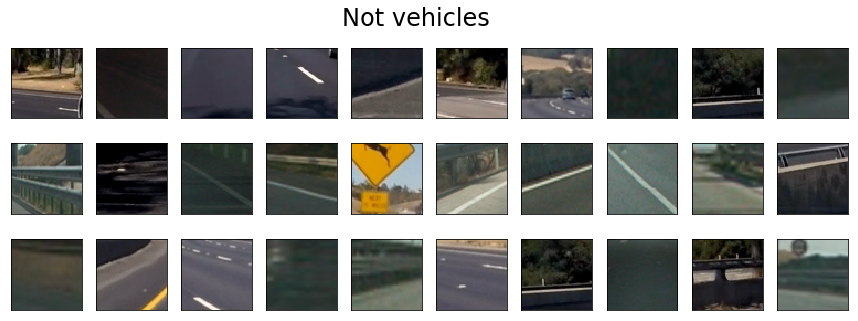

In [3]:
non_vehicles_images_names = glob.glob("data/non-vehicles/non-vehicles/**/*.png")
vehicles_images_names = glob.glob("data/vehicles/vehicles/**/*.png")    

visualize_input_data(vehicles_images_names, 'Vehicles', random=True)
visualize_input_data(non_vehicles_images_names, 'Not vehicles', random=True)

## Prepare test data and visualize how HOG works for selected colorspace

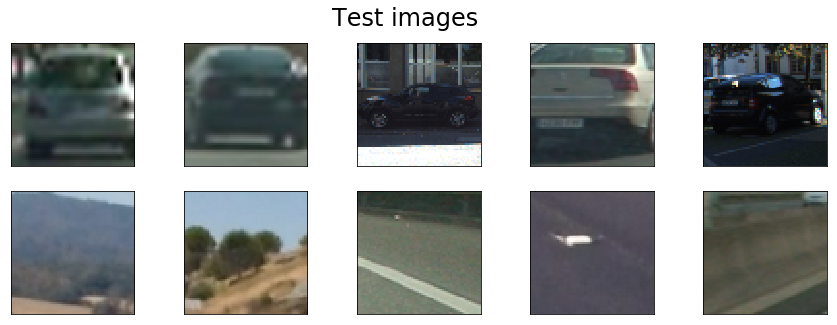

In [4]:
np.random.seed(13)
min_length = np.amin([len(non_vehicles_images_names), len(vehicles_images_names)])
random_indices = np.random.randint(low=0, high=min_length, size=5)

test_images_names = []
for i in random_indices:
    test_images_names.append(vehicles_images_names[i])
for i in random_indices:
    test_images_names.append(non_vehicles_images_names[i])

visualize_input_data(test_images_names, 'Test images', cols=5, rows=2)

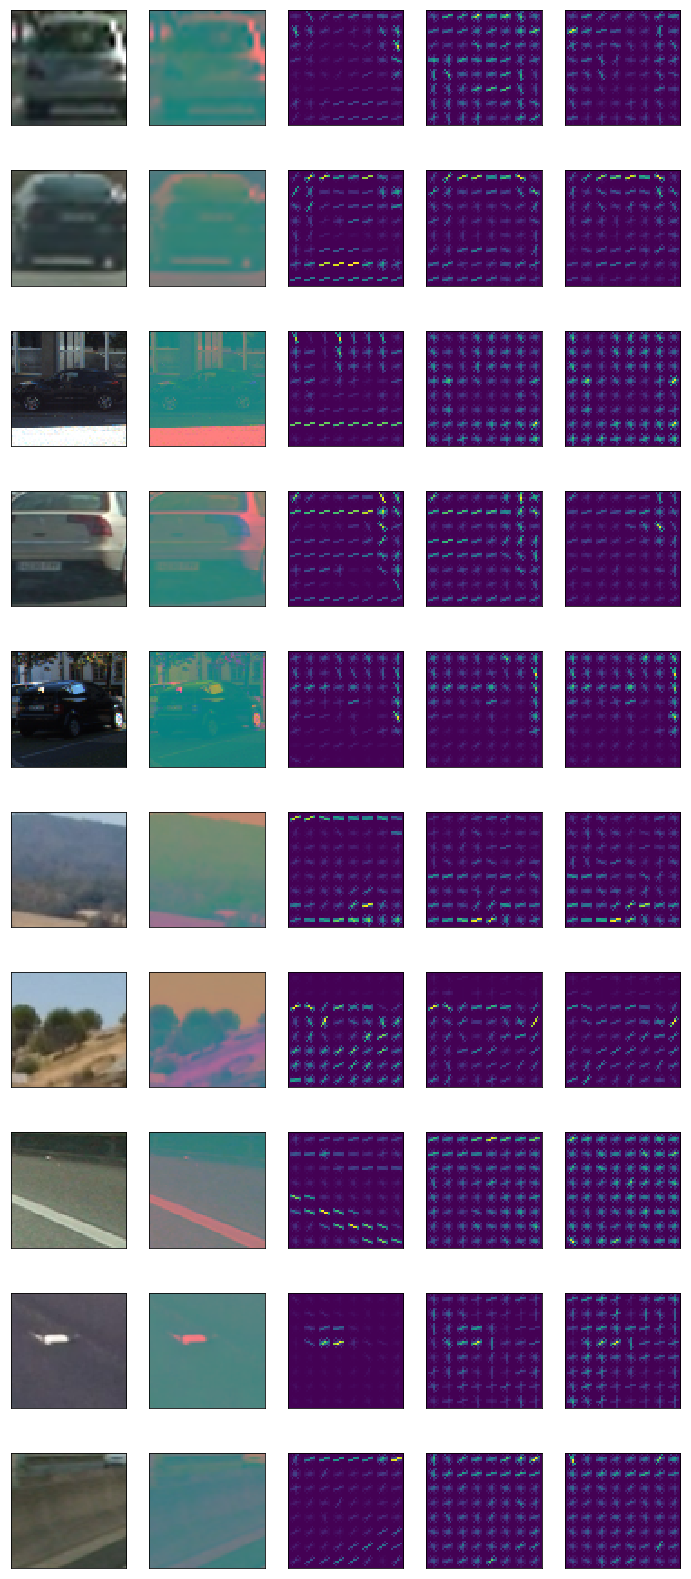

In [5]:
rows = []
for test_image_name in test_images_names:
    row = []
    image = mpimg.imread(test_image_name)
    hog_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    row.append(image)
    row.append(hog_image)

    for i in range(3):
        hog_features, hog_visualization = get_hog_features(hog_image[:, :, i], vis=True)
        row.append(hog_visualization)
        
    rows.append(row)
    
show_rows(rows)

### Extract and cache features

In [6]:
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
colorspace='YUV'

try:
    vehicle_features = pickle.load(open("vehicle_features.pickle", "rb"))
    non_vehicle_features = pickle.load(open("non_vehicle_features.pickle", "rb"))
except (OSError, IOError) as e:
    vehicle_features = extract_features(
        vehicles_images_names,
        orient=orient,
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        hog_channel=hog_channel,
        cspace=colorspace
    )
    non_vehicle_features = extract_features(
        non_vehicles_images_names,
        orient=orient,
        pix_per_cell=pix_per_cell,
        cell_per_block=cell_per_block,
        hog_channel=hog_channel,
        cspace=colorspace
    )

    pickle.dump(vehicle_features, open("vehicle_features.pickle", "wb"))
    pickle.dump(non_vehicle_features, open("non_vehicle_features.pickle", "wb"))

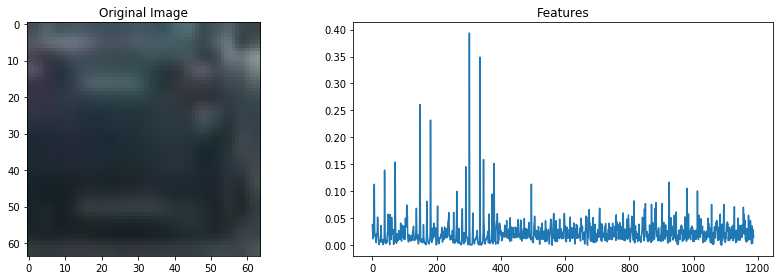

In [7]:
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
Y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

show_normalization(vehicles_images_names, X, 13)

## Split dataset into train and validation subsets

In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train size: {}".format(train_labels.shape[0]))
print("Test size: {}".format(test_labels.shape[0]))

Train size: 14208
Test size: 3552


## Train classifier

In [9]:
svc = LinearSVC()

t = time.time()
svc.fit(train_features, train_labels)
t2 = time.time()

print(round(t2 - t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(test_features, test_labels), 4))

0.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9828


### Search cars using non-optimized sliding window

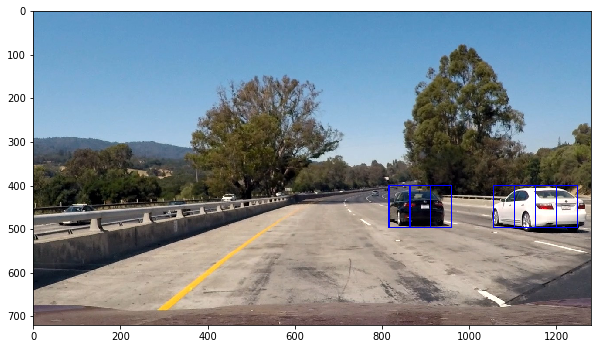

In [10]:
vehicle_img = mpimg.imread("test_images/test1.jpg")

ystart = 400
ystop = 700
scale = 1.5

recs = Search.find_cars(vehicle_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace)
plt.figure(figsize=(10, 15))
plt.imshow(draw_boxes(vehicle_img, recs))

### Provide an example how windows are distributed when search regions are applied

Text(0.5,1,'Search regions')

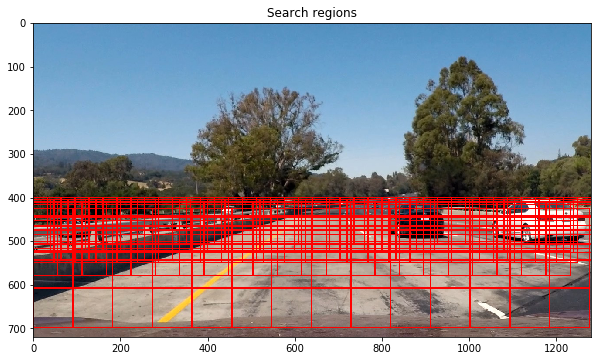

In [11]:
vehicle_img = mpimg.imread("test_images/test1.jpg")

test_rects = []
for (start, stop, scale) in Search.search_regions:
    rect = Search.find_cars(vehicle_img, start, stop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace, True)
    vehicle_img = draw_boxes(vehicle_img, rect, (255, 0, 0))


plt.figure(figsize=(10, 15))
plt.imshow(vehicle_img)
plt.title("Search regions")

## Demonstrate how optimized sliding window works

Text(0.5,1,'Find cars with combinations of search regions')

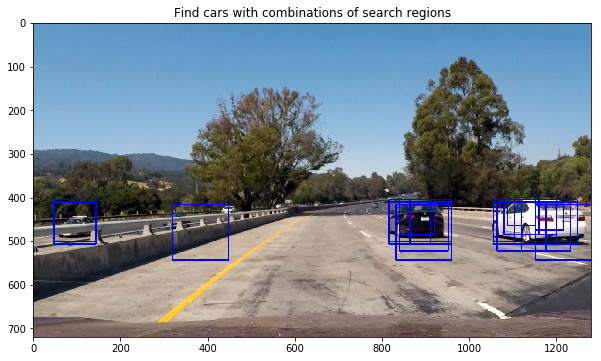

In [12]:
vehicle_img = mpimg.imread("test_images/test1.jpg")
boxes = Search.find_cars_with_search_regions(vehicle_img, svc, orient, pix_per_cell, cell_per_block, colorspace)
plt.figure(figsize=(10, 15))
plt.imshow(draw_boxes(vehicle_img, boxes))
plt.title("Find cars with combinations of search regions")

### Provide an example of how heatmap can be used in order to reduce false positives

Text(0.5,1,'Final processed frame')

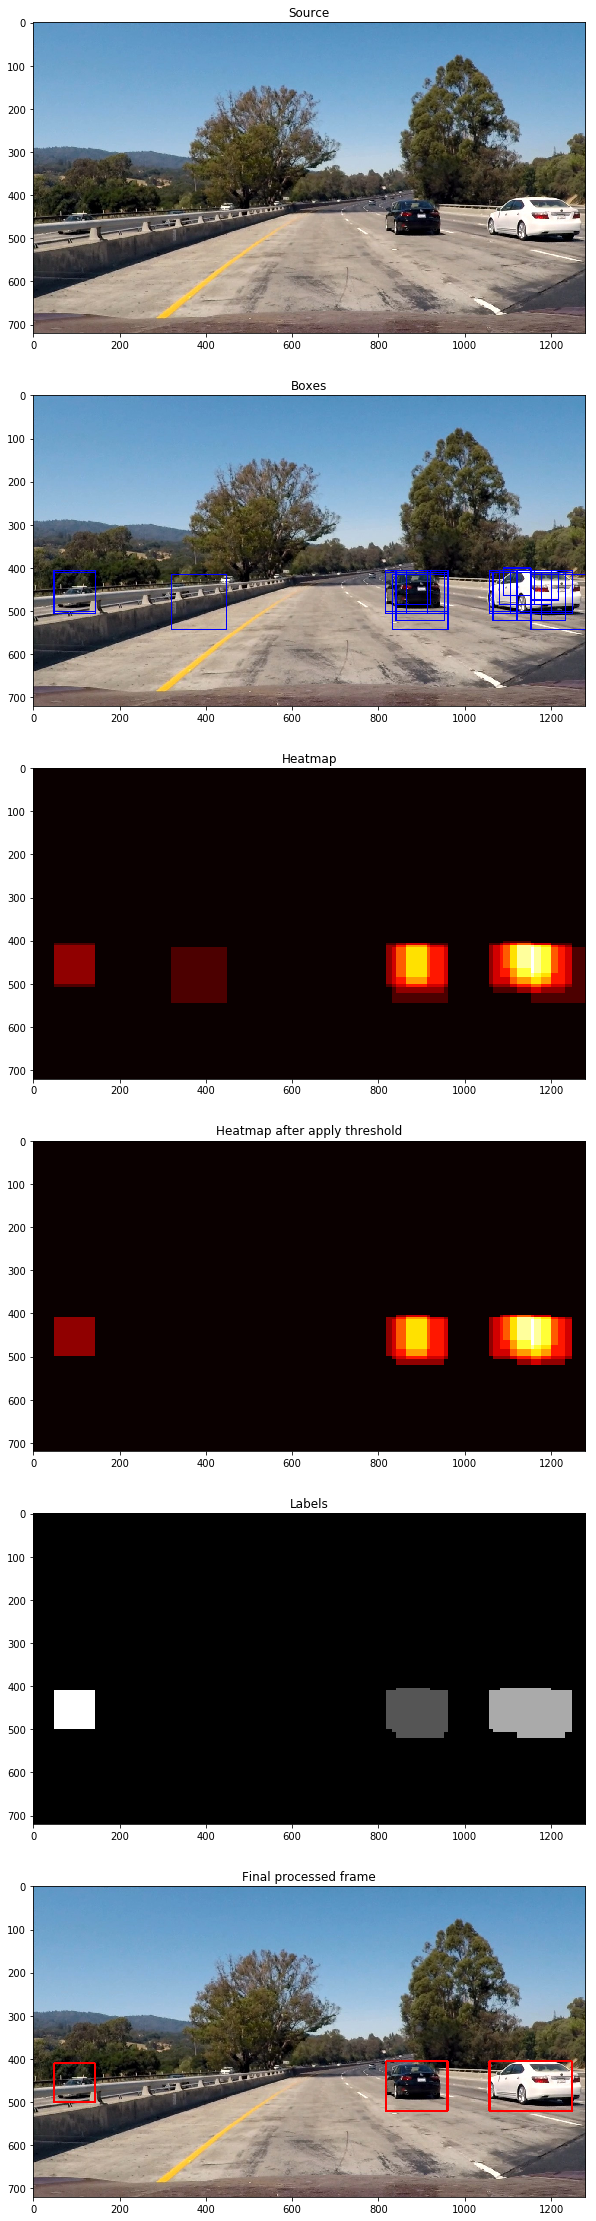

In [13]:
vehicle_img = mpimg.imread("test_images/test1.jpg")

plt.figure(figsize=(23, 40))
plt.subplot(611)
plt.title("Source")
plt.imshow(vehicle_img)

boxes = Search.find_cars_with_search_regions(vehicle_img, svc, orient, pix_per_cell, cell_per_block, colorspace)
plt.subplot(612)
plt.title("Boxes")
plt.imshow(draw_boxes(vehicle_img, boxes))


heat = np.zeros_like(vehicle_img[:, :, 0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, Search.find_cars_with_search_regions(vehicle_img, svc, orient, pix_per_cell, cell_per_block, colorspace))
plt.subplot(613)
plt.title("Heatmap")
plt.imshow(heat, cmap="hot")

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
plt.subplot(614)
plt.title("Heatmap after apply threshold")
plt.imshow(heatmap, cmap="hot")

# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.subplot(615)
plt.title("Labels")
plt.imshow(labels[0], cmap="gray")

draw_img = draw_labeled_bboxes(np.copy(vehicle_img), labels)
plt.subplot(616)
plt.imshow(draw_img)
plt.title("Final processed frame")

### Define a pipeline for video processing

In [14]:
#This variable need for storing previous founded boxes of cars
prev_boxes_list = []

def process_frame(img):
    global prev_boxes_list
    boxes = Search.find_cars_with_search_regions(
        img,
        svc,
        orient,
        pix_per_cell,
        cell_per_block,
        colorspace
    )
    
    if len(boxes) > 0:
        prev_boxes_list.append(boxes)
        
    if len(prev_boxes_list) > 13:
        prev_boxes_list = prev_boxes_list[len(prev_boxes_list) - 13:]
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    
    for boxes in prev_boxes_list:    
        heat = add_heat(heat, boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)

    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

video_out_file = "project_processed_video.mp4"
video = VideoFileClip("project_video.mp4")
video = video.fl_image(process_frame)
%time video.write_videofile(video_out_file, audio=False)

-----------------------
None
ffmpeg -i project_video.mp4
-----------------------
-----------------------
None
ffmpeg -i project_video.mp4 -loglevel error -f image2pipe -vf scale=1280:720 -sws_flags bicubic -pix_fmt rgb24 -vcodec rawvideo -
-----------------------
-----------------------
None
ffmpeg -i project_video.mp4
-----------------------
-----------------------
None
ffmpeg -i project_video.mp4 -vn -loglevel error -f s16le -acodec pcm_s16le -ar 44100 -ac 2 -
-----------------------
[MoviePy] >>>> Building video project_processed_video.mp4
[MoviePy] Writing video project_processed_video.mp4
-----------------------
None
ffmpeg -y -loglevel error -f rawvideo -vcodec rawvideo -s 1280x720 -pix_fmt rgb24 -r 25.00 -i - -an -vcodec libx264 -preset medium -pix_fmt yuv420p project_processed_video.mp4
-----------------------


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:22<00:00,  3.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_processed_video.mp4 

Wall time: 6min 23s
